# 1D Simulácia

## Simulácia odrazu elektromagnetickej vlny od ideálne vodivej prekážky.

Prostredie je tvorené lineárnou postupnosťou buniek reprezentujúcich oblasť simulácie v smere osi Z, na krajoch je ohraničené ideálnym absorbérom PML, vo vnútri oblasti sa na jednom konci nachádza generátor impulzu so zložkou $E_x$ a na druhom dokonalý kovový vodič M s $\epsilon_r = \infty$. Bunky prostredia označené V reprezentujú ideálne vákuum.

<img src="./img/obr_1d_config.png" width=400 alt="Konfigurácia jednorozmerného simulačného prostredia" scale="0.7">


In [1]:
%reset -f 
%matplotlib inline

import meep as mp
import pylab as plt
from scipy import *

Using MPI version 3.0, 1 processes


### Definícia oblasti simulácie

Definícia oblasti simulácie pozostáva z definovania rozmerov simulačnej oblasti a vytvorenia zoznamu objektov  oblasti. Objekty presahujúce rozmery sú ignorované. Okolo simulovanej oblasti (z vnútornej strany) je možné vytvoriť ideálny absorbér s definovanou hrúbkou.

In [2]:
size = 200                        # pocet buniek v simulacii
res = 20                          # rozlisenie - rozdelenie buniek 

area = mp.Vector3(0, 0, size)     # definovanie rozmerov oblasti simulacie (1D) 
                                  # v smere osi Z

geometry = [                      # definicia vlastnosti prostredia pomocou 1D blokov
    mp.Block(mp.Vector3(0,0,size-2), center=mp.Vector3(0,0,0),          material=mp.vacuum),
    mp.Block(mp.Vector3(0,0,1),      center=mp.Vector3(0,0,size/2-1.5), material=mp.metal) 
  ]

pml_layers = mp.PML(1.0)          # idealny obsorber okolo oblasti simulacie

### Vytvorenie a definícia zdrojov

Okrem sady preddefinovaných typov zdrojov je možné v *meep* definovať aj zdroje vlastné, v našom prípade zdroj generujúci impulz posunutý v čase on $t_0$ v tvare Gaussovej krivky o šírke $w$.

\begin{equation}
s(t) = exp \, ( {-\frac{(t - t_0)^2} {w} } )
\end{equation}

Zdrojov môže byť v simulovanom prostredí niekoľko, v definícii určíme polohu zdroja, zložku elektromagnetickej vlny a amplitúdu. Zdroje zaraddíme do zoznamu, ktorý sa odovzdá v parametroch objektu simulácie.

In [3]:
def pulse(t):
    return -2*exp(-(t -20.)**2 / 20.0)

sources = [mp.Source(mp.CustomSource(src_func=pulse), component=mp.Ex,
                     center=mp.Vector3(0, 0, -size/2 + 1),  
                     amplitude=1.0)
          ]

### Vytvorenie objektu simulácie

Rozmery simulačnej oblasti, zoznam objektov v oblasti a zdrojov odovzdáme ako parametre triede *Simulation*.

In [4]:
sim = mp.Simulation(               # vytvorenie objektu simulacie s parametrami
    cell_size=area,                
    geometry=geometry,
    sources=sources,
    boundary_layers=[pml_layers],
    resolution=res,
    dimensions=1)

### Simulácia šírenia sa impulzu

Simuláciu môžeme spustiť pomocou metódy *run* s argumentom určujúcim dobu simulácie.

In [5]:
sim.run(until=70)     # doba simulacie 200 krokov, impul je oneskoreny 20 jednotiek
data_1 = sim.get_efield_x()

-----------
Initializing structure...
run 0 finished at t = 70.0 (2800 timesteps)


In [6]:
sim.run(until=200)     # pokracovanie simulacie o dalsich 200 krokov
data_2 = sim.get_efield_x()

run 1 finished at t = 270.0 (10800 timesteps)


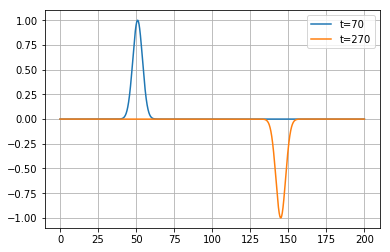

In [7]:
x = arange(len(data_1))/res

plt.plot(x, real(data_1), label='t=70')  # impulz v case 70 jednotiek, poloha 52 - zdroj je na pozicii [1]
plt.plot(x, real(data_2), label='t=270')  # impulz v case 270, poloha 158 - dlzka oblasti je 200 - 4 
plt.grid()
plt.legend()
plt.show()

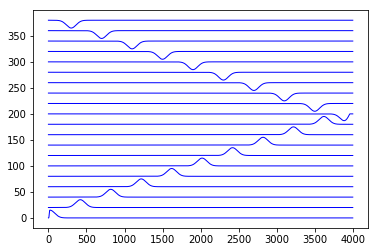

In [8]:
from IPython.utils import io

sim.reset_meep()                    # restart simulacie

fig = plt.figure() #figsize=(10, 7), facecolor='r')
ax = fig.add_subplot(111)

for i in range(20):
    
    with io.capture_output() as captured:
        sim.run(until=20);     # pokracovanie simulacie o dalsich 200 krokov
    data = real(sim.get_efield_x()) * 15
    ax.plot(data +i*20, 'b', lw=1) 
plt.show()

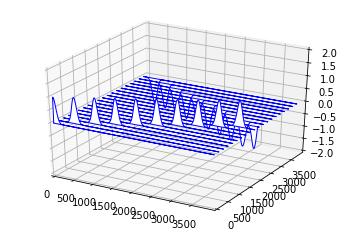

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection

sim.reset_meep()       # restart simulacie

fig = plt.figure() #figsize=(15, 10)) 
ax = fig.add_subplot(111, projection='3d')

trace = 20
t = arange(0, size*res)[:,None]*ones(trace)   #np.linspace(-50,50,100)
y = arange(trace)
vert=[]

for i in range(len(y)):
    with io.capture_output() as captured:
        sim.run(until=20);                 # pokracovanie simulacie o dalsich 200 krokov
    data = real(sim.get_efield_x())        # nacitanie dat
    vert.append(list(zip(t[:,i], data)))   # poskladanie dvojic pre polygon
    
    
poly = PolyCollection(vert, facecolors=(1,1,1,1), edgecolors=(0,0,1,1))
ax.add_collection3d(poly, zdir='y', zs=range(0, len(y)*200, 200 )) 
    
ax.set_xlim3d(t.min(), t.max())
ax.set_ylim3d(t.min(), t.max())
ax.set_zlim3d(-2, 2)
plt.show()